In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
transform = transforms.ToTensor()

In [3]:
# load the training data in a folder and call it cnn_data
train_data = datasets.MNIST(root= '/cnn_data', train= True, download= True, transform= transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 14.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 575kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.61MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.61MB/s]


In [4]:
# load the test data in the same way
test_data = datasets.MNIST(root= '/cnn_data', train= False, download= True, transform= transform)

In [5]:
train_loader = DataLoader(train_data, batch_size= 10, shuffle= True)
test_loader = DataLoader(test_data, batch_size= 10, shuffle= True)

# Creating the architecture step by step

In [6]:
# Defining the convolution layer
conv1 = nn.Conv2d(1, 6, 3, 1)
conv2 = nn.Conv2d(6, 16, 3, 1)

In [7]:
# grab 1 MNIST image/record
for i, (X_train, Y_train) in enumerate(train_data):
    break

In [8]:
X_train.shape

torch.Size([1, 28, 28])

In [9]:
# adjust the shape of X_train
X = X_train.view(1, 1, 28, 28)

In [10]:
X = F.relu(conv1(X))
X.shape

torch.Size([1, 6, 26, 26])

In [11]:
X = F.max_pool2d(X, 2, 2)
X.shape

torch.Size([1, 6, 13, 13])

In [12]:
X = F.relu(conv2(X))
X.shape

torch.Size([1, 16, 11, 11])

In [13]:
X = F.max_pool2d(X, 2, 2)
X.shape

torch.Size([1, 16, 5, 5])

# Creating a class to define the model architecture

In [14]:
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
     super().__init__()
     self.conv1 = nn.Conv2d(1, 6, 3, 1)
     self.conv2 = nn.Conv2d(6, 16, 3, 1)
     # fully connected layers
     self.fc1 = nn.Linear(5*5*16, 120)
     self.fc2 = nn.Linear(120, 84)
     self.fc3 = nn.Linear(84, 10)

  def forward(self, X):
    X = F.relu(self.conv1(X)) # this is considered 1 perceptron
    X = F.max_pool2d(X, 2, 2)

    X = F.relu(self.conv2(X)) # Changed from self.conv1 to self.conv2
    X = F.max_pool2d(X, 2, 2)


    # reshape
    X = X.view(-1, 16*5*5)

    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = X = self.fc3(X)

    return F.log_softmax(X, dim= 1)

In [15]:
torch.manual_seed(41)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [16]:
# Loss Function Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Smaller the Learning Rate, longer its gonna take to train.

In [17]:
import time
start_time = time.time()

# Create Variables To Tracks Things
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# For Loop of Epochs
for i in range(epochs):
  trn_corr = 0
  tst_corr = 0


  # Train
  for b,(X_train, Y_train) in enumerate(train_loader):
    b+=1 # start our batches at 1
    y_pred = model(X_train) # get predicted values from the training set. Not flattened 2D
    loss = criterion(y_pred, Y_train) # how off are we? Compare the predictions to correct answers in y_train

    predicted = torch.max(y_pred.data, 1)[1] # add up the number of correct predictions. Indexed off the first point
    batch_corr = (predicted == Y_train).sum() # how many we got correct from this batch. True = 1, False=0, sum those up
    trn_corr += batch_corr # keep track as we go along in training.

    # Update our parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    # Print out some results
    if b%600 == 0:
      print(f'Epoch: {i}  Batch: {b}  Loss: {loss.item()}')

  train_losses.append(loss)
  train_correct.append(trn_corr)


  # Test
  with torch.no_grad(): #No gradient so we don't update our weights and biases with test data
    for b,(X_test, Y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data, 1)[1] # Adding up correct predictions
      tst_corr += (predicted == Y_test).sum() # T=1 F=0 and sum away


  loss = criterion(y_val, Y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)



current_time = time.time()
total = current_time - start_time
print(f'Training Took: {total/60} minutes!')

Epoch: 0  Batch: 600  Loss: 0.1623610556125641
Epoch: 0  Batch: 1200  Loss: 0.1502392590045929
Epoch: 0  Batch: 1800  Loss: 0.4744560718536377
Epoch: 0  Batch: 2400  Loss: 0.14238706231117249
Epoch: 0  Batch: 3000  Loss: 0.007758188061416149
Epoch: 0  Batch: 3600  Loss: 0.3836284875869751
Epoch: 0  Batch: 4200  Loss: 0.0038223876617848873
Epoch: 0  Batch: 4800  Loss: 0.0021286322735249996
Epoch: 0  Batch: 5400  Loss: 0.0569545142352581
Epoch: 0  Batch: 6000  Loss: 0.00038789428072050214
Epoch: 1  Batch: 600  Loss: 0.02950388565659523
Epoch: 1  Batch: 1200  Loss: 0.01223783753812313
Epoch: 1  Batch: 1800  Loss: 0.0017079260433092713
Epoch: 1  Batch: 2400  Loss: 0.004794587381184101
Epoch: 1  Batch: 3000  Loss: 0.00012589071411639452
Epoch: 1  Batch: 3600  Loss: 0.006774441804736853
Epoch: 1  Batch: 4200  Loss: 0.00024002441205084324
Epoch: 1  Batch: 4800  Loss: 0.011869433335959911
Epoch: 1  Batch: 5400  Loss: 0.0003403539885766804
Epoch: 1  Batch: 6000  Loss: 0.0003896451380569488
Epoc

In [19]:
from google.colab import drive; drive.mount('/content/drive')

Mounted at /content/drive


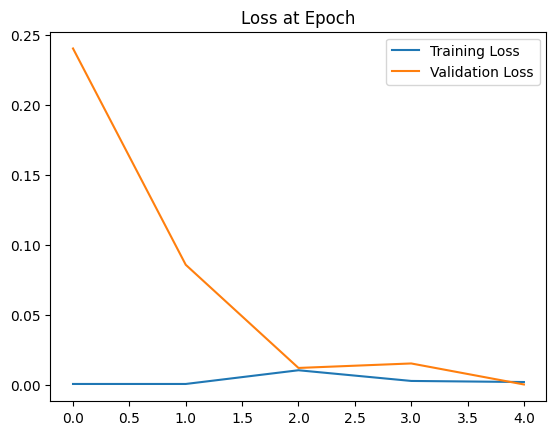

In [20]:
# Graph the loss at epoch
train_losses = [tl.item() for tl in train_losses]
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Validation Loss")
plt.title("Loss at Epoch")
plt.legend()

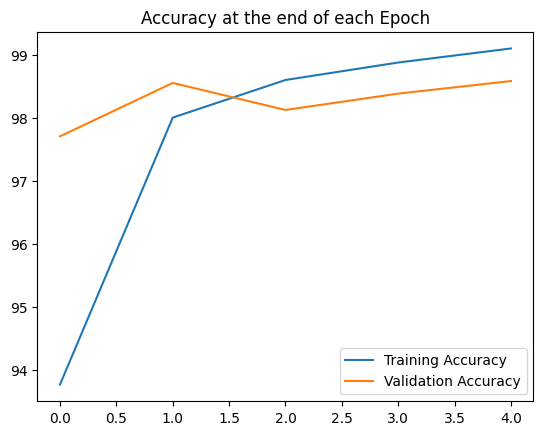

In [21]:
# graph the accuracy at the end of each epoch
plt.plot([t/600 for t in train_correct], label="Training Accuracy")
plt.plot([t/100 for t in test_correct], label="Validation Accuracy")
plt.title("Accuracy at the end of each Epoch")
plt.legend()

In [32]:
test_load_everything = DataLoader(test_data, batch_size=10000, shuffle=False)

In [33]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_everything:
    y_val = model(X_test)
    predicted = torch.max(y_val, 1)[1]
    correct += (predicted == y_test).sum()

In [34]:
# Did for correct
correct.item()/len(test_data)*100

98.59

In [42]:
# Grab an image
numb = 3012
test_data[numb] # Tensor with an image in it...at end, it shows the label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [43]:
# Grab just the data
test_data[numb][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [44]:
# Reshape it
test_data[numb][0].reshape(28,28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

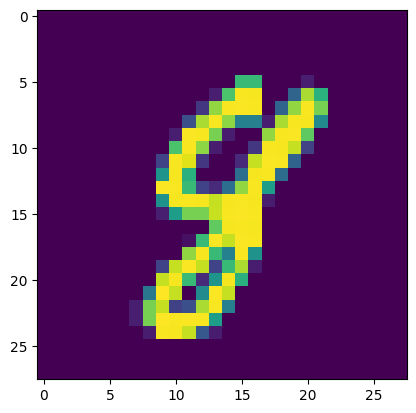

In [45]:
# Show the image
plt.imshow(test_data[numb][0].reshape(28,28))

In [46]:
# Pass the image thru our model
model.eval()
with torch.no_grad():
  new_prediction = model(test_data[numb][0].view(1,1,28,28)) # batch size of 1, 1 color channel, 28x28 image

In [47]:
# Check the new prediction...get probabilities
new_prediction

tensor([[-1.6724e+01, -9.9787e+00, -1.1470e+01, -1.4017e+01, -5.2540e+00,
         -1.0329e+01, -1.2070e+01, -1.1438e+01, -5.3704e-03, -1.0687e+01]])

In [48]:
new_prediction.argmax()

tensor(8)